<center><h1> Machine Learning Engineer Nanodegree</h1>
    <h3>Capstone Project</h3>
    <br><h2>Covnets for Medical Diagnosis</h2>
</center><br>
This notebook contains code to visualize the dataset and implement the model. It also contains description of code and the structure of the Convolution Neural Network, along with the justification of choosing the parameters for implmentation. A helper file by the name of "helper.py" is also included in the same directory as this jupyter notebook, which implements some helper functions we will be using throughout this project to load, process or visualize the data. For analysis of the project, please refer to the project report added along with this notebook.

### Getting  and visualising the data
Execute the following code cell to load and visualize the dataset.


Example of Image 435:
Id of image: 00002331_001.png
Finding Labels: Pneumothorax
Age: 066Y      
Sex: F


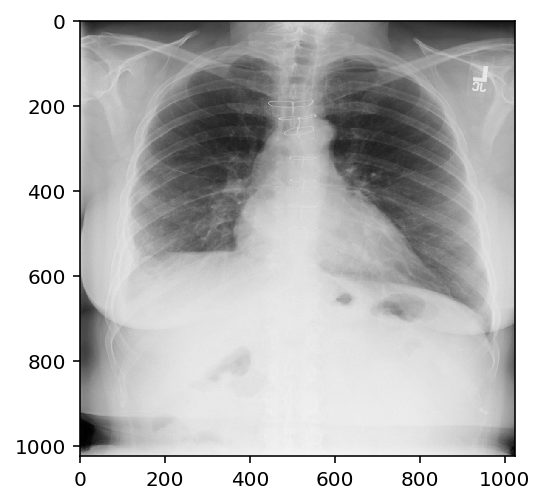

In [2]:
from os.path import isfile, isdir
import helper
import numpy as np

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

if not isdir('sample/images'):
    print('Dataset is not present. Please download it using the drive link provided in the README.md file.')
else:
    sample_no=435 #from 1 to 5606
    helper.display_stats('sample/images', sample_no)

The following cell implements the normalization and one-hot encoding function, and then uses these functions to preprocess and save data to disk, which will be needed by us in this project.

In [1]:
#This code cell is to display statistics about the complete dataset.
def normalize(x):
    """
    Normalize a list of sample image data in the range of 0 to 1
    : x: List of image data.  The image shape is (256, 256, 3)
    : return: Numpy array of normalize data
    """
    # TODO: Implement Function
    normalized_arr = np.zeros(tuple(x.shape))
    n = x.shape[0]
    # Computing max/min values.
    max_val, min_val = x.max(), x.min()
    # Transforming every image.
    for i in range(n):
        normalized_arr[i,...] = (x[i, ...] - float(min_val)) / float(max_val - min_val)    
    return normalized_arr


def one_hot_encode(x):
    """
    One hot encode a list of sample labels. Return a one-hot encoded vector for each label.
    : x: List of sample Labels
    : return: Numpy array of one-hot encoded labels
    """
    # TODO: Implement Function
    l=len(x)
    #"b" is the array in which the one hot encoded values will be stored
    b=np.zeros((l,15))
    #iterating each element and thus assigning 1 at the corresponding value in "b"
    for i in range(0,l):
        b[i][x[i]]=1
    return b
helper.preprocess_and_save_data('.', normalize, one_hot_encode)

The following code cell will visualize the data by creating a bar graph indicating the number of samples per class, and a heat map indicating the overlapping extent of different labels in our multi-labeled output. The inferences from these graphs are drawn in the prject report.

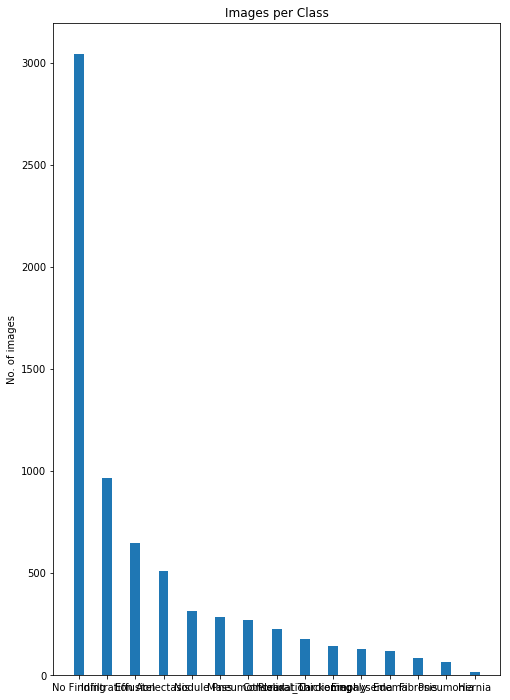

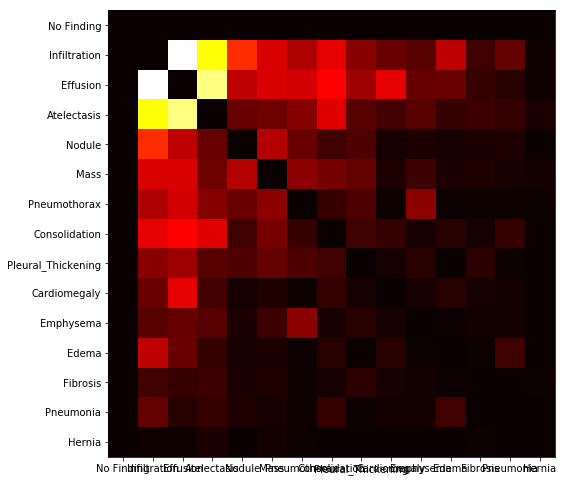

In [33]:
import tensorflow as tf
import numpy as np
import helper
import matplotlib.pyplot as plt

total = np.zeros(15)
aa = np.zeros((15,15))
for i in range(1,14):
    labels = helper.load_labels(i,one_hot_encode)
    total += np.count_nonzero(labels,0)
    aa += np.matmul(np.transpose(labels),labels)
p = plt.bar(np.arange(15),total,0.35)
plt.ylabel('No. of images')
plt.xticks(np.arange(15),helper._load_label_names())
plt.title('Images per Class')
plt.rcParams["figure.figsize"]=[8,12]
plt.show()
for i in range(15):
    for j in range(15):
        if(i==j):
            aa[i][j]=0
plt.imshow(aa, cmap='hot', interpolation='nearest')
plt.xticks(np.arange(15),helper._load_label_names())
plt.yticks(np.arange(15),helper._load_label_names())
plt.show()

### Checkpoint 1
You can restart this notebook from this given point if you decide to come back to this project, after closing it. The data has been processed and saved to disk.

### Vanilla Neural Network
The following code will first flatten the image, then feed it to a simple neural network with only one hidden layer, and hence, calculates the F-score.

In [2]:
import helper
import numpy as np
import tensorflow as tf
import pickle

def neural_net_image_input(image_shape):
    return tf.placeholder(tf.float32,shape=(None,image_shape[0],image_shape[1],image_shape[2]),name="x")


def neural_net_label_input(n_classes):
    return tf.placeholder(tf.float32, shape=[None,n_classes], name="y")


def neural_net_keep_prob_input():
    return tf.placeholder(tf.float32, shape=(None), name="keep_prob")

tf.reset_default_graph()

In [3]:
def flatten(x_tensor):
    tensor_shape = x_tensor.get_shape().as_list()
    #length of the flattened dimensions.
    flattened_shape = np.array(tensor_shape[1:]).prod()
    # Batch size is casted by tf.shape.
    return tf.reshape(x_tensor, [tf.shape(x_tensor)[0], flattened_shape])
def fully_conn(x_tensor, num_outputs):
    #shape after flattening
    flattened_shape = np.array(x_tensor.get_shape().as_list()[1:]).prod()
    # weight and bias
    weights = tf.Variable(tf.truncated_normal([flattened_shape, num_outputs], stddev=0.4))
    bias = tf.Variable(tf.zeros([num_outputs]))
    
    # Fully connected layer
    fc = tf.nn.sigmoid(tf.add(tf.matmul(x_tensor, tf.cast(weights,tf.float32)), tf.cast(bias,tf.float32)))        
    return fc
def van_net(x, keep_prob):
    output=flatten(x)
    output=fully_conn(output, 5)
    output=tf.nn.dropout(output, keep_prob)
    output=fully_conn(output, 15)
    return output
tf.reset_default_graph()

# Inputs
x = neural_net_image_input((256, 256, 3))
y = neural_net_label_input(15)
keep_prob = neural_net_keep_prob_input()

# Model
logits = van_net(x, keep_prob)

# Name logits Tensor, so that is can be loaded from disk after training
logits = tf.identity(logits, name='logits')

# F-Measure
max_arr=tf.multiply(tf.cast(0.5,tf.float32),tf.cast(tf.equal(logits,logits),tf.float32))
pred=tf.cast(tf.less(max_arr,logits),tf.float32)
tp = tf.count_nonzero(pred * y)
fp = tf.count_nonzero(pred * (y - 1))
fn = tf.count_nonzero((pred - 1) * y)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
fmeasure = 2*((tp)/(2*tp+fp+fn))

# Loss and Optimizer
cost = tf.reduce_mean(tf.nn.weighted_cross_entropy_with_logits(logits=logits, targets=y, pos_weight=5))
optimizer = tf.train.AdamOptimizer(epsilon=0.0001).minimize(cost)


def train_neural_network(session, optimizer, keep_probability, feature_batch, label_batch):
    session.run(optimizer, feed_dict={x: feature_batch,
                                      y: label_batch,
                                      keep_prob: keep_probability})
def print_stats(session, feature_batch, label_batch, cost, fmeasure, batch_size):
    loss = sess.run(cost, feed_dict={x: feature_batch,
                                     y: label_batch,
                                     keep_prob: 1.})
    valid_fscore=0.0
    j=0.
    for valid_features,valid_labels in helper.load_valid_batch(batch_size):
        valid_fscore += (sess.run(fmeasure, feed_dict={x: valid_features,
                                                        y: valid_labels,
                                                        keep_prob: 1.}))
        j = j+1.
    valid_fscore = valid_fscore/j
    print('Loss: {:>10.4f} Validation F-Score: {:.6f}'.format(loss, valid_fscore))
    return valid_fscore

Let's check the validity of the neural network on only a single batch first:

In [4]:
epochs = 10
batch_size = 150
keep_probability = 0.5

In [5]:
print('Checking the Training on a Single Batch...')

with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        batch_i = 1
        for batch_features, batch_labels in helper.load_preprocess_training_batch(batch_i, batch_size):
            train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels)
        print('Epoch {:>2}, CovMD Batch {}:  '.format(epoch + 1, batch_i), end='')
        print_stats(sess, batch_features, batch_labels, cost, fmeasure,batch_size)

Checking the Training on a Single Batch...
Epoch  1, CovMD Batch 1:  Loss:     1.0792 Validation F-Score: 0.181720
Epoch  2, CovMD Batch 1:  Loss:     1.0781 Validation F-Score: 0.180421
Epoch  3, CovMD Batch 1:  Loss:     1.0772 Validation F-Score: 0.183116
Epoch  4, CovMD Batch 1:  Loss:     1.0763 Validation F-Score: 0.184385
Epoch  5, CovMD Batch 1:  Loss:     1.0753 Validation F-Score: 0.184984
Epoch  6, CovMD Batch 1:  Loss:     1.0740 Validation F-Score: 0.188854
Epoch  7, CovMD Batch 1:  Loss:     1.0734 Validation F-Score: 0.208754
Epoch  8, CovMD Batch 1:  Loss:     1.0706 Validation F-Score: 0.222014
Epoch  9, CovMD Batch 1:  Loss:     1.0699 Validation F-Score: 0.232512
Epoch 10, CovMD Batch 1:  Loss:     1.0686 Validation F-Score: 0.213782


Since, the neural network seems to be fit for learning from our data, let's carry on with feeding all the features we have, to the given vanilla neural net:

In [6]:
epochs = 10
batch_size = 150
keep_probability = 0.5

In [7]:
save_model_path = './van_model'

print('Training (Validating only once per epoch)...')
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        # Loop over all batches
        n_batches = 13
        for batch_i in range(1, n_batches + 1):
            for batch_features, batch_labels in helper.load_preprocess_training_batch(batch_i, batch_size):
                train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels)
        print('Epoch {:>2}:  '.format(epoch + 1), end='')
        print_stats(sess, batch_features, batch_labels, cost, fmeasure,batch_size)    
    # Save Model
    saver = tf.train.Saver()
    save_path = saver.save(sess, save_model_path)


Training (Validating only once per epoch)...
Epoch  1:  Loss:     1.0676 Validation F-Score: 0.256853
Epoch  2:  Loss:     1.0536 Validation F-Score: 0.260683
Epoch  3:  Loss:     1.0400 Validation F-Score: 0.260731
Epoch  4:  Loss:     1.0271 Validation F-Score: 0.293573
Epoch  5:  Loss:     1.0150 Validation F-Score: 0.369239
Epoch  6:  Loss:     1.0040 Validation F-Score: 0.369239
Epoch  7:  Loss:     0.9938 Validation F-Score: 0.369239
Epoch  8:  Loss:     0.9699 Validation F-Score: 0.369239
Epoch  9:  Loss:     0.9589 Validation F-Score: 0.369239
Epoch 10:  Loss:     0.9500 Validation F-Score: 0.369239


The learning of the vanilla neural network has converged to a training loss of 0.95 and a value of 0.369 for the F-score on the training batch. These figures will be used as a benchmark for our convolution neural network.

### Checkpoint 2
The vanilla neural net has been saved to disk, so you can start from this point onwards, if you decide to return to this project after closing it.

### Convolution Neural Network -- CovMD
The following cells implement a convolution model with the following structure (Here CL-Convolution Layer, ML-Maxpool layer, Flatten-Flattening layer, FCL-Fully Connected layer followed by dropout, Out-Output Layer):
CL1->CL2->ML1->CL3->CL24->ML2->CL5->CL6->ML3->CL7->CL8->ML4->CL9->CL10->ML5->Flatten->FCL1->FCL2->Out<br>
A better visualisation is there in the project report.

In [2]:
import helper
import numpy as np
import tensorflow as tf
import pickle

def neural_net_image_input(image_shape):
    return tf.placeholder(tf.float16,shape=(None,image_shape[0],image_shape[1],image_shape[2]),name="x")


def neural_net_label_input(n_classes):
    return tf.placeholder(tf.float16, shape=[None,n_classes], name="y")


def neural_net_keep_prob_input():
    return tf.placeholder(tf.float16, shape=(None), name="keep_prob")

tf.reset_default_graph()

def flatten(x_tensor):
    tensor_shape = x_tensor.get_shape().as_list()
    #length of the flattened dimensions.
    flattened_shape = np.array(tensor_shape[1:]).prod()
    # Batch size is casted by tf.shape.
    return tf.reshape(x_tensor, [tf.shape(x_tensor)[0], flattened_shape])

def fully_conn(x_tensor, num_outputs):
    #shape after flattening
    flattened_shape = np.array(x_tensor.get_shape().as_list()[1:]).prod()
    # weight and bias
    weights = tf.Variable(tf.truncated_normal([flattened_shape, num_outputs], stddev=0.04))
    bias = tf.Variable(tf.zeros([num_outputs]))
    
    # Fully connected layer
    fc = tf.nn.sigmoid(tf.add(tf.matmul(x_tensor, tf.cast(weights,tf.float16)), tf.cast(bias,tf.float16)))        
    return fc

def conv_layer(x_tensor, conv_num_outputs, conv_ksize, conv_strides):
    #weight and bias for convolution layer
    weight=tf.Variable(tf.truncated_normal([conv_ksize[0],conv_ksize[1],x_tensor.get_shape().as_list()[3],conv_num_outputs],stddev=5e-2))
    bias=tf.Variable(tf.zeros(conv_num_outputs))
    #convolution layer
    conv_tensor=tf.nn.conv2d(input=x_tensor,
                             filter=tf.cast(weight,tf.float16), 
                             strides=[1,conv_strides[0],conv_strides[1],1], 
                             padding="SAME")
    conv_tensor=tf.nn.bias_add(conv_tensor,tf.cast(bias,tf.float16))
    conv_tensor=tf.nn.relu(conv_tensor)
    return conv_tensor

def maxpool_layer(x_tensor, pool_ksize, pool_strides):
    #pooling layer
    maxpool=tf.nn.max_pool(value=x_tensor,
                           ksize=[1,pool_ksize[0],pool_ksize[1],1],
                           strides=[1,pool_strides[0],pool_strides[1],1],
                           padding="SAME")
    return maxpool

def conv_net(x, keep_prob):
    #(2 convolution layers and 1 max pooling layer) X 5
    conv = conv_layer(x,
                           conv_num_outputs=8,
                           conv_ksize=[5,5],
                           conv_strides=[1,1])
    conv = conv_layer(conv,
                           conv_num_outputs=8,
                           conv_ksize=[5,5],
                           conv_strides=[2,2])
    conv = maxpool_layer(conv,
                           pool_ksize=[3,3],
                           pool_strides=[2,2])
    conv = conv_layer(conv,
                           conv_num_outputs=16,
                           conv_ksize=[5,5],
                           conv_strides=[1,1])
    conv = conv_layer(conv,
                           conv_num_outputs=16,
                           conv_ksize=[5,5],
                           conv_strides=[2,2])
    conv = maxpool_layer(conv,
                           pool_ksize=[3,3],
                           pool_strides=[2,2])
    conv = conv_layer(conv,
                           conv_num_outputs=32,
                           conv_ksize=[5,5],
                           conv_strides=[1,1])
    conv = conv_layer(conv,
                           conv_num_outputs=32,
                           conv_ksize=[5,5],
                           conv_strides=[2,2])
    conv = maxpool_layer(conv,
                           pool_ksize=[3,3],
                           pool_strides=[2,2])
    conv = conv_layer(conv,
                           conv_num_outputs=64,
                           conv_ksize=[5,5],
                           conv_strides=[1,1])
    conv = conv_layer(conv,
                           conv_num_outputs=64,
                           conv_ksize=[5,5],
                           conv_strides=[1,1])
    conv = maxpool_layer(conv,
                           pool_ksize=[5,5],
                           pool_strides=[2,2])
    conv = conv_layer(conv,
                           conv_num_outputs=128,
                           conv_ksize=[5,5],
                           conv_strides=[1,1])
    conv = conv_layer(conv,
                           conv_num_outputs=128,
                           conv_ksize=[5,5],
                           conv_strides=[1,1])
    conv = maxpool_layer(conv,
                           pool_ksize=[5,5],
                           pool_strides=[2,2])

    flat = flatten(conv)

    #Two fully connected layers followed by dropout
    fc=fully_conn(flat, 50)
    fc = tf.nn.dropout(fc, keep_prob)
    fc=fully_conn(fc, 30)
    fc = tf.nn.dropout(fc, keep_prob)

    return fully_conn(fc, 15)


The following cell shows the implementation of cost function and optimization, and implements the functions to calculate training loss and F-score. The details of the cost function and optimization algorithm used here are given in the project report.

In [3]:
# Inputs
x = neural_net_image_input((256, 256, 3))
y = neural_net_label_input(15)
keep_prob = neural_net_keep_prob_input()

# Model
logits = conv_net(x, keep_prob)

# Name logits Tensor, so that is can be loaded from disk after training
logits = tf.identity(logits, name='logits')

# Loss and Optimizer
cost = tf.reduce_mean(tf.nn.weighted_cross_entropy_with_logits(logits=logits, targets=y, pos_weight=5))
optimizer = tf.train.AdamOptimizer().minimize(cost)

# F-Measure
max_arr=tf.multiply(tf.cast(0.5,tf.float16),tf.cast(tf.equal(logits,logits),tf.float16))
pred=tf.cast(tf.less(max_arr,logits),tf.float16)
tp = tf.count_nonzero(pred * y)
fp = tf.count_nonzero(pred * (y - 1))
fn = tf.count_nonzero((pred - 1) * y)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
fmeasure = 2*(tp/(2*tp+fp+fn))

def train_neural_network(session, optimizer, keep_probability, feature_batch, label_batch):
    session.run(optimizer, feed_dict={x: feature_batch,
                                      y: label_batch,
                                      keep_prob: keep_probability})
def print_stats(session, feature_batch, label_batch, cost, fmeasure, batch_size):
    loss = sess.run(cost, feed_dict={x: feature_batch,
                                     y: label_batch,
                                     keep_prob: 1.})
    valid_fscore=0.0
    for valid_features,valid_labels in helper.load_valid_batch(batch_size):
        valid_fscore = valid_fscore+(sess.run(fmeasure, feed_dict={x: valid_features,
                                                        y: valid_labels,
                                                        keep_prob: 1.}))
    valid_fscore = (valid_fscore*batch_size)/560.  #Taking the average
    print('Loss: {:>10.4f} Validation F-Score: {:.10f}'.format(loss, valid_fscore))
    return valid_fscore

Checking the validity of the CNN on only a single batch first:

In [4]:
epochs = 10
batch_size = 150
keep_probability = 0.5

In [5]:
print('Checking the Training on a Single Batch...')
prev_score=0.0
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        batch_i = 1
        for batch_features, batch_labels in helper.load_preprocess_training_batch(batch_i, batch_size):
            train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels)
        print('Epoch {:>2}, CovMD Batch {}:  '.format(epoch + 1, batch_i), end='')
        print_stats(sess, batch_features, batch_labels, cost, fmeasure, batch_size)

Checking the Training on a Single Batch...
Epoch  1, CovMD Batch 1:  Loss:     1.0732 Validation F-Score: 0.1302430480
Epoch  2, CovMD Batch 1:  Loss:     1.0625 Validation F-Score: 0.3650780523
Epoch  3, CovMD Batch 1:  Loss:     1.0498 Validation F-Score: 0.3916690558
Epoch  4, CovMD Batch 1:  Loss:     1.0264 Validation F-Score: 0.5337893987
Epoch  5, CovMD Batch 1:  Loss:     1.0137 Validation F-Score: 0.5337893987
Epoch  6, CovMD Batch 1:  Loss:     1.0029 Validation F-Score: 0.5337893987
Epoch  7, CovMD Batch 1:  Loss:     0.9907 Validation F-Score: 0.5337893987
Epoch  8, CovMD Batch 1:  Loss:     0.9819 Validation F-Score: 0.5337893987
Epoch  9, CovMD Batch 1:  Loss:     0.9741 Validation F-Score: 0.5337893987
Epoch 10, CovMD Batch 1:  Loss:     0.9673 Validation F-Score: 0.5337893987


Since, the training for a single batch seems to converge in just 5 epochs, and since it is estimated to take around one and a half days to carry out just 5 epochs on my 2 GHz CPU, I'll train the CNN with the complete dataset for only 5 epochs:

In [6]:
epochs = 5
batch_size = 150
keep_probability = 0.5

In [7]:
save_model_path = './conv_model'

print('Training (Validating only once per epoch)...')
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        # Loop over all batches
        n_batches = 13
        for batch_i in range(1, n_batches + 1):
            for batch_features, batch_labels in helper.load_preprocess_training_batch(batch_i, batch_size):
                train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels)
        print('Epoch {:>2}:  '.format(epoch + 1), end='')
        print_stats(sess, batch_features, batch_labels, cost, fmeasure,batch_size)    
    # Save Model
    saver = tf.train.Saver()
    save_path = saver.save(sess, save_model_path)


Training (Validating only once per epoch)...
Epoch  1:  Loss:     0.9697 Validation F-Score: 0.5337893987
Epoch  2:  Loss:     0.9663 Validation F-Score: 0.5337893987
Epoch  3:  Loss:     0.9380 Validation F-Score: 0.5337893987
Epoch  4:  Loss:     0.9380 Validation F-Score: 0.5337893987
Epoch  5:  Loss:     0.9390 Validation F-Score: 0.5337893987


The training loss has (almost) converged to a value of 0.939 and the F-score has ceratinly converged to 0.533. This result is (marginally) better as compared to the result obtained by training a vanilla neural network. <br>
Let's compare the 2 models by calculating the F-score on the test batches that we reserved out of our dataset.<br>

### Checkpoint 3
The convolution model is trained and saved to disk.

### Testing Phase
The following cells will load the testing data and then calculate the F-score by running both the models on the same testing data.

In [10]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import tensorflow as tf
import pickle
import helper
import random

# Set batch size if not already set
batch_size=150


save_model_path = './van_model'


def test_model():
    """
    Test the saved model against the test dataset
    """
    # Get accuracy in batches for memory limitations
    test_batch_f_total = 0.
    test_batch_prec_total = 0.
    test_batch_rec_total = 0.
    test_batch_count = 0.
    for i in range(1,3):
        test_features, test_labels = pickle.load(open('preprocess_training_'+str(i)+'.p', mode='rb'))
        loaded_graph = tf.Graph()

        with tf.Session(graph=loaded_graph) as sess:
            # Load model
            loader = tf.train.import_meta_graph(save_model_path + '.meta')
            loader.restore(sess, save_model_path)
            
            # Get Tensors from loaded model
            loaded_x = loaded_graph.get_tensor_by_name('x:0')
            loaded_y = loaded_graph.get_tensor_by_name('y:0')
            loaded_keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')
            loaded_logits = loaded_graph.get_tensor_by_name('logits:0')
            #I forgot to name the fmeasure, precision and recall tensors while creating and saving the graph, so I searched the nodes from the graph maps.
            loaded_fmeasure = loaded_graph.get_tensor_by_name('mul_4:0')
            loaded_precision = loaded_graph.get_tensor_by_name('truediv:0')
            loaded_recall = loaded_graph.get_tensor_by_name('truediv_1:0')
            
            for train_feature_batch, train_label_batch in helper.batch_features_labels(test_features, test_labels, batch_size):
                test_batch_f, test_batch_prec, test_batch_rec = sess.run(
                    [loaded_fmeasure,loaded_precision,loaded_recall],
                    feed_dict={loaded_x: train_feature_batch, loaded_y: train_label_batch, loaded_keep_prob: 1.0})
                test_batch_f_total += test_batch_f
                test_batch_prec_total += test_batch_prec
                test_batch_rec_total += test_batch_rec
                test_batch_count += 1
    if(save_model_path=='./van_model'):
        print('Vanilla Model Testing:')
    else:
        print('Convolution Model Testing:')
    print('F-Score: {} Precision: {} Recall: {}'.format(test_batch_f_total/test_batch_count,test_batch_prec_total/test_batch_count,test_batch_rec_total/test_batch_count))

test_model()
save_model_path = './conv_model'
test_model()

INFO:tensorflow:Restoring parameters from ./van_model
INFO:tensorflow:Restoring parameters from ./van_model
Vanilla Model Testing:
F-Score: 0.3497990765797406 Precision: 0.28515151515151516 Recall: 0.45278599748781434
INFO:tensorflow:Restoring parameters from ./conv_model
INFO:tensorflow:Restoring parameters from ./conv_model
Convolution Model Testing:
F-Score: 0.4746056797536484 Precision: 0.5364393939393939 Recall: 0.4258412816119522


<ul>
<li>On the testing data, clearly the covnet model has  margin over the benchmark model, if we consider the F-score. The F-score of our model has reached 0.47, which is satisfactoy, keeping in mind the limiting factor of the resources at my disposal.</li>
<li>Moreover, as calculated above, the precision of the model has reached 0.53 (from 0.28 in our benchmark model). This indicates that out of all the positives that this model gives as predictions, more than 50% are reliable and can be trusted to be true positives.</li>
<li>Thirdly, the recall is 0.425, which means that if the person has a disease, there is a 42.5% chance that our model will be able to predict it.</li>
</ul>
<p>Keeping in mind, that the resolution of images used was just 256X256, and the covnet was not as deep as it could have been, due to limitation of computing resources, the results obtained are fairly satisfactory.</p>